In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import mdtraj as md
import nglview as nv
import numpy as np
import os

## Load trajectory

In [3]:
traj_file = "../4_complex_preparation/traj.h5"
traj = md.load(traj_file)
print(traj)
print(traj.topology)

<mdtraj.Trajectory with 1000 frames, 27425 atoms, 8028 residues, and unitcells>
<mdtraj.Topology with 4 chains, 8028 residues, 27425 atoms, 19689 bonds>


In [4]:
view = nv.show_mdtraj(traj)
#view.add_licorice(selection="(not protein)")
view

NGLWidget(max_frame=999)

## Compute RMSD

In [5]:
ligand_traj = traj.atom_slice(traj.topology.select("not protein and not water"))
# Unselect ions
ligand_traj = ligand_traj.atom_slice(ligand_traj.topology.select("chainid == 0"))
print(ligand_traj)
print(ligand_traj.topology)

<mdtraj.Trajectory with 1000 frames, 44 atoms, 1 residues, and unitcells>
<mdtraj.Topology with 1 chains, 1 residues, 44 atoms, 47 bonds>


In [6]:
protein_traj = traj.atom_slice(traj.topology.select("protein"))
print(protein_traj)
print(protein_traj.topology)

<mdtraj.Trajectory with 1000 frames, 4058 atoms, 250 residues, and unitcells>
<mdtraj.Topology with 1 chains, 250 residues, 4058 atoms, 4096 bonds>


In [7]:
rmsd_prot = md.rmsd(protein_traj, protein_traj, 0)
rmsd_lig = md.rmsd(ligand_traj, ligand_traj, 0)
print(rmsd_prot.shape)

(1000,)


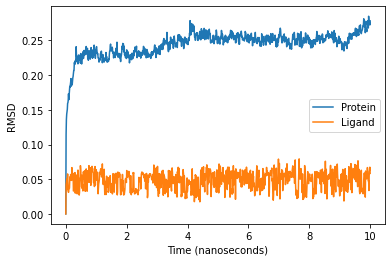

In [8]:
time = np.linspace(0, 10, num=1000)

fig, ax = plt.subplots()
ax.plot(time, rmsd_prot, label="Protein")
ax.plot(time, rmsd_lig, label="Ligand")
ax.set_xlabel("Time (nanoseconds)")
ax.set_ylabel("RMSD")
ax.legend()
plt.show()

## Get pharmacophore points for some frames

In [9]:
from openpharmacophore.structured_based import StructuredBasedPharmacophore 

In [10]:
start = traj[0]
middle = traj[499]
end = traj[-1]

print("First Frame: {}".format(start))
print("Middle Frame: {}".format(middle))
print("Last Frame: {}".format(end))

First Frame: <mdtraj.Trajectory with 1 frames, 27425 atoms, 8028 residues, and unitcells>
Middle Frame: <mdtraj.Trajectory with 1 frames, 27425 atoms, 8028 residues, and unitcells>
Last Frame: <mdtraj.Trajectory with 1 frames, 27425 atoms, 8028 residues, and unitcells>


In [11]:
def pharmacophore_from_frame(frame):
    temp_filename = "./temp.pdb"
    frame.save_pdb(temp_filename)

    # The pdb mdtraj generates needs to be edited so that pybel can read it.
    # The third line that contains "MODEL" needs to be removed for the structured 
    # based pharmacophore to work.
    remove_line_from_file(file=temp_filename, line="MODEL")
    pharmacophore = StructuredBasedPharmacophore.from_pdb(temp_filename)
    
    os.remove(temp_filename)
    return pharmacophore

In [12]:
def remove_line_from_file(file, line):
    with open(file, "r+") as f:
        d = f.readlines()
        f.seek(0)
        for i in d:
            if  not i.startswith(line):
                f.write(i)
        f.truncate()

In [13]:
start_pharmacophore = pharmacophore_from_frame(start)
start_pharmacophore

StructuredBasedPharmacophore(n_elements: 5)

In [14]:
start_pharmacophore.show()

NGLWidget()

In [15]:
# Pharmacophore for middle frame
middle_pharmacophore = pharmacophore_from_frame(middle)
middle_pharmacophore

StructuredBasedPharmacophore(n_elements: 4)

In [23]:
middle_pharmacophore.elements

[HBAcceptorSphereAndVector(center: (26.493, 19.812, 22.445); radius: 1.0; direction: (0.2016, -0.8838, 0.4222)),
 HBAcceptorSphereAndVector(center: (36.179, 15.285, 24.479); radius: 1.0; direction: (-0.6204, 0.5922, 0.5142)),
 HBDonorSphereAndVector(center: (26.493, 19.812, 22.445); radius: 1.0; direction: (-0.1575, 0.9459, 0.2835)),
 HydrophobicSphere(center: (34.5338, 15.4854, 22.6358); radius: 1.0)]

In [16]:
middle_pharmacophore.show()

NGLWidget()

In [17]:
end_pharmacophore = pharmacophore_from_frame(end)
end_pharmacophore

StructuredBasedPharmacophore(n_elements: 4)

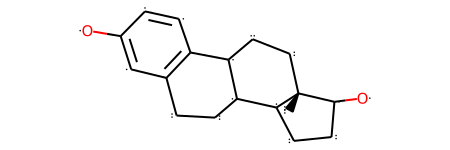

In [21]:
end_pharmacophore.ligand

In [22]:
end_pharmacophore.elements

[HBAcceptorSphereAndVector(center: (21.4, 23.433, 23.959); radius: 1.0; direction: (0.9029, 0.0437, 0.4276)),
 HBAcceptorSphereAndVector(center: (32.187, 20.784, 24.975); radius: 1.0; direction: (-0.8643, 0.3032, 0.4012)),
 HBDonorSphereAndVector(center: (21.4, 23.433, 23.959); radius: 1.0; direction: (-0.9257, -0.2297, 0.3006)),
 HydrophobicSphere(center: (30.007, 20.079, 23.7292); radius: 1.0)]

In [18]:
end_pharmacophore.show()

NGLWidget()

In [20]:
traj.n_frames

1000